In [7]:
import pandas as pd
import numpy as np

from pathlib import Path


In [36]:
BASE = Path("../data")

ticker = "MS"
date = '2025-06-02'

quotes_fp_ms = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
q = pd.read_parquet(quotes_fp_ms)
q.head()

,ts,symbol,bid_price,ask_price,bid_size,ask_size,mid,spread,imbalance_l1,microprice,microprice_dev
0,2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
1,2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2,2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
3,2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355
4,2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355


## Merge data

In [42]:
BASE = Path("../data")

ticker = "SPY"
date = '2025-06-02'

quotes_fp_spy = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp_spy = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp_spy = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

In [43]:
q = pd.read_parquet(quotes_fp_ms)
q.head()

,ts,symbol,bid_price,ask_price,bid_size,ask_size,mid,spread,imbalance_l1,microprice,microprice_dev
0,2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
1,2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2,2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
3,2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355
4,2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355


In [44]:
q = pd.read_parquet(quotes_fp_ms).set_index('ts').add_prefix("q_")
q.shape


(23399, 10)

In [45]:
q.head()

,q_symbol,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev
ts,,,,,,,,,,
2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355
2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355


In [46]:
q.columns

Index(['q_symbol', 'q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size',
       'q_mid', 'q_spread', 'q_imbalance_l1', 'q_microprice',
       'q_microprice_dev'],
      dtype='object')

In [81]:
def build_panel_1s(quotes_fp: Path, prices_fp: Path, trades_fp: Path) -> pd.DataFrame:
    q = pd.read_parquet(quotes_fp).set_index('ts').add_prefix("q_")
    p = pd.read_parquet(prices_fp).set_index('ts').add_prefix("p_")
    t = pd.read_parquet(trades_fp).set_index('ts').add_prefix("t_")

    # Inner join = only timestamps where all three exist
    panel = q.join(p, how="inner").join(t, how="inner")

    quote_cols = [c for c in panel.columns if c.startswith("q_")]
    panel[quote_cols] = panel[quote_cols].ffill()

    # Drop any rows that still have missing core state
    panel = panel.dropna(subset=["q_mid", "q_spread"])

    return panel


In [82]:
ticker = "MS"
quotes_fp = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"


panel = build_panel_1s(quotes_fp, prices_fp, trades_fp)
print(panel.shape)
print(panel.columns)
print(panel.head())


(23399, 23)
Index(['q_symbol', 'q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size',
       'q_mid', 'q_spread', 'q_imbalance_l1', 'q_microprice',
       'q_microprice_dev', 'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close',
       'p_volume', 'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades',
       't_vwap', 't_symbol'],
      dtype='object')
                          q_symbol  q_bid_price  q_ask_price  q_bid_size  \
ts                                                                         
2025-06-02 09:30:01-04:00       MS       126.50       127.98       200.0   
2025-06-02 09:30:02-04:00       MS       126.50       127.98       200.0   
2025-06-02 09:30:03-04:00       MS       126.50       127.98       200.0   
2025-06-02 09:30:04-04:00       MS       126.56       127.98       200.0   
2025-06-02 09:30:05-04:00       MS       126.56       127.98       200.0   

                           q_ask_size   q_mid  q_spread  q_imbalance_l1  \
ts                             

## Feature Engineering

In [83]:
panel.columns

Index(['q_symbol', 'q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size',
       'q_mid', 'q_spread', 'q_imbalance_l1', 'q_microprice',
       'q_microprice_dev', 'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close',
       'p_volume', 'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades',
       't_vwap', 't_symbol'],
      dtype='object')

In [84]:
# z-score regime window size
w = 300 # 5min

# add targets
panel['y_ret_5s'] = np.log(panel['q_mid']).shift(-5) - np.log(panel['q_mid'])
panel['y_ret_30s'] = np.log(panel['q_mid']).shift(-30) - np.log(panel['q_mid'])

# add features
panel['x_spread_bps'] = 1e4 * panel['q_spread'] / panel['q_mid']
panel['x_imb_l1'] = panel['q_imbalance_l1']
panel['x_mp_dev'] = panel['q_microprice_dev']

# trade intensity + volume shocks
panel["x_ntrades"] = panel["t_n_trades"]
panel["x_volume"] = panel["t_volume"]

panel['x_ntrades_z'] = (panel['x_ntrades'] - panel['x_ntrades'].rolling(w).mean()) / panel['x_ntrades'].rolling(w).std()
panel['x_volume_z'] = (panel['x_volume'] - panel['x_volume'].rolling(w).mean()) / panel['x_volume'].rolling(w).std()

# vwap pressure
panel["x_vwap_mid_bps"] = 1e4 * (panel["t_vwap"] - panel["q_mid"]) / panel["q_mid"]

# short-horizon vol regime
panel["x_ret_1s"] = np.log(panel["q_mid"]).diff()
panel["x_realized_vol_30s"] = panel["x_ret_1s"].rolling(30).std()

# quote update
panel["x_quote_update"] = (
    (panel["q_bid_price"].diff() != 0) | (panel["q_ask_price"].diff() != 0)
).astype(int)
panel["x_quote_update_30s"] = panel["x_quote_update"].rolling(30).mean()

feat_cols = [c for c in panel.columns if c.startswith("x_")]
target_cols = ["y_ret_5s", "y_ret_30s"]

df = panel.dropna(subset=feat_cols + target_cols).copy()



In [85]:
panel

,q_symbol,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev,...,x_mp_dev,x_ntrades,x_volume,x_ntrades_z,x_volume_z,x_vwap_mid_bps,x_ret_1s,x_realized_vol_30s,x_quote_update,x_quote_update_30s
ts,,,,,,,,,,,,,,,,,,,,,
2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.240,1.48,-0.500000,126.870000,-0.370000,...,-0.370000,12,323,NaN,NaN,-21.465493,NaN,NaN,1,NaN
2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.240,1.48,-0.500000,126.870000,-0.370000,...,-0.370000,6,6,NaN,NaN,-3.667610,0.000000,NaN,0,NaN
2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.240,1.48,-0.500000,126.870000,-0.370000,...,-0.370000,1,4,NaN,NaN,-20.433826,0.000000,NaN,0,NaN
2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.270,1.42,-0.500000,126.915000,-0.355000,...,-0.355000,1,1,NaN,NaN,35.357901,0.000236,NaN,1,NaN
2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.270,1.42,-0.500000,126.915000,-0.355000,...,-0.355000,2,12,NaN,NaN,32.607842,0.000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02 15:59:55-04:00,MS,128.38,128.41,800.0,300.0,128.395,0.03,0.454545,128.401818,0.006818,...,0.006818,18,496,0.181315,-0.360142,-0.012562,0.000000,0.000096,0,0.733333
2025-06-02 15:59:56-04:00,MS,128.41,128.43,100.0,400.0,128.420,0.02,-0.600000,128.414000,-0.006000,...,-0.006000,52,2726,2.196858,1.414328,-0.830541,0.000195,0.000100,1,0.733333
2025-06-02 15:59:57-04:00,MS,128.41,128.44,100.0,2700.0,128.425,0.03,-0.928571,128.411071,-0.013929,...,-0.013929,82,4585,3.872552,2.848262,0.091758,0.000039,0.000100,1,0.733333


## Predictability Test

In [86]:
feat_cols = [c for c in df.columns if c.startswith("x_")]

ic_5s = df[feat_cols].corrwith(df["y_ret_5s"], method="spearman")
ic_30s = df[feat_cols].corrwith(df["y_ret_30s"], method="spearman")


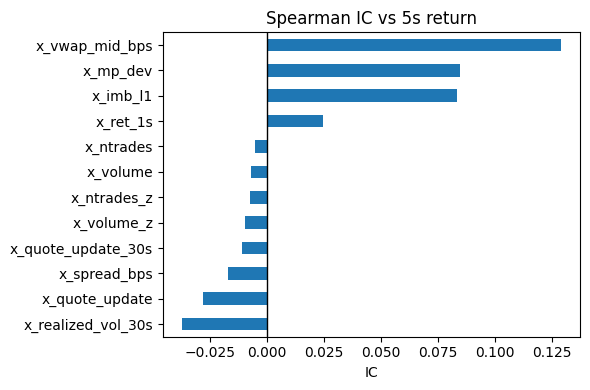

In [87]:
import matplotlib.pyplot as plt

# Spearman Information Coefficient

ic_5s.sort_values().plot(kind="barh", figsize=(6,4))
plt.axvline(0, color="black", linewidth=1)
plt.title("Spearman IC vs 5s return")
plt.xlabel("IC")
plt.tight_layout()
plt.show()


- top-of-the-book imbalance seems to be reflecting the return after 5s strongly.
- microprice deviation also reflects strong positive correlation with 5s return.

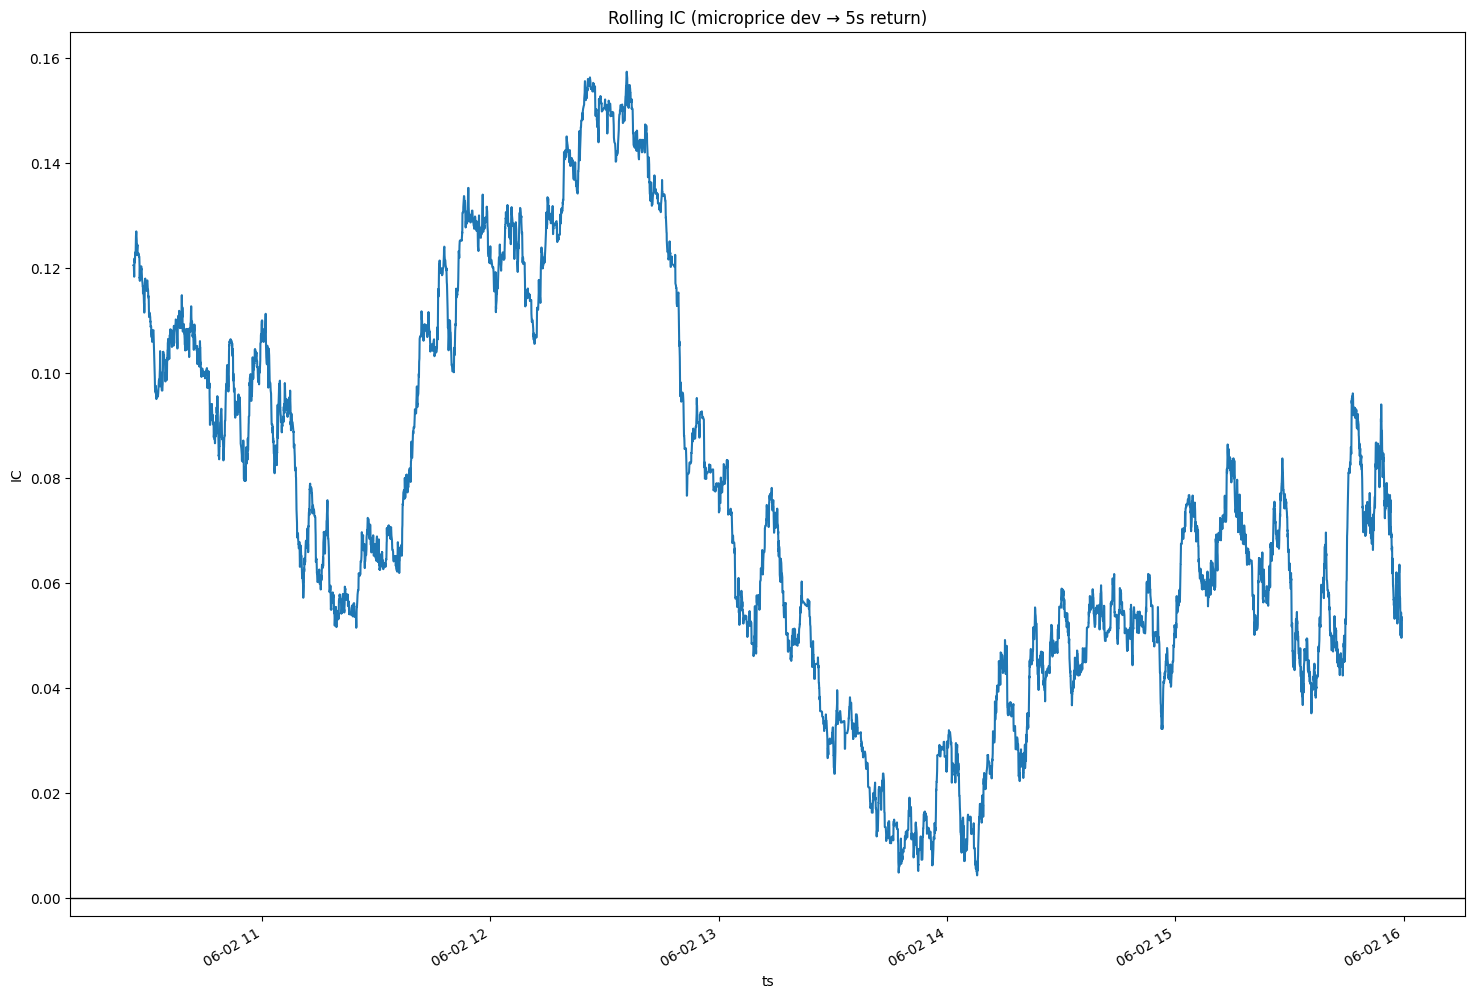

In [88]:
def rolling_ic(x, y, window):
    window = 1800  # e.g. 30 minutes at 1s

    x_rank = x.rank()
    y_rank = y.rank()

    rolling_ic = x_rank.rolling(window).corr(y_rank)
    return rolling_ic

ic_ts = rolling_ic(df["x_mp_dev"], df["y_ret_5s"], window=1800)  # 30 min

ic_ts.plot(figsize=(18,13))
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling IC (microprice dev → 5s return)")
plt.ylabel("IC")
plt.show()


## Horizon Decay

In [89]:
ics = {}

horizons = [1, 5, 10, 20, 30, 60] # seconds

for h in horizons:
    y = np.log(df['q_mid'].shift(-h)) - np.log(df['q_mid'])
    ics[h] = df['x_imb_l1'].corr(y, method='spearman')

ic_decay = pd.Series(ics)


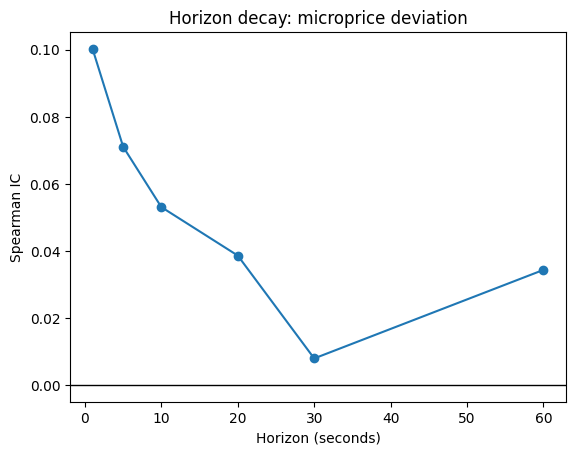

In [90]:
ic_decay.plot(marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Horizon (seconds)")
plt.ylabel("Spearman IC")
plt.title("Horizon decay: microprice deviation")
plt.show()


## Rel Val

In [91]:
BASE = Path("../data")

ticker = "MS"
date = '2025-06-02'

quotes_fp_gs = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

df = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
df = df[['q_mid']]
df

,q_mid
ts,
2025-06-02 09:30:01-04:00,127.240
2025-06-02 09:30:02-04:00,127.240
2025-06-02 09:30:03-04:00,127.240
2025-06-02 09:30:04-04:00,127.270
2025-06-02 09:30:05-04:00,127.270
...,...
2025-06-02 15:59:55-04:00,128.395
2025-06-02 15:59:56-04:00,128.420
2025-06-02 15:59:57-04:00,128.425


In [92]:
quotes_fp_gs = BASE / "quotes" / f"SPY_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"SPY_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"SPY_trades_1s_{date}.parquet"
df_market = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
df_market = df_market[['q_mid']]
df_market

,q_mid
ts,
2025-06-02 09:30:00-04:00,587.915
2025-06-02 09:30:01-04:00,588.090
2025-06-02 09:30:02-04:00,588.145
2025-06-02 09:30:03-04:00,588.025
2025-06-02 09:30:04-04:00,588.055
...,...
2025-06-02 15:59:55-04:00,592.545
2025-06-02 15:59:56-04:00,592.645
2025-06-02 15:59:57-04:00,592.725


In [93]:
ts = df.index.intersection(df_market.index)
ts

DatetimeIndex(['2025-06-02 09:30:01-04:00', '2025-06-02 09:30:02-04:00',
               '2025-06-02 09:30:03-04:00', '2025-06-02 09:30:04-04:00',
               '2025-06-02 09:30:05-04:00', '2025-06-02 09:30:06-04:00',
               '2025-06-02 09:30:07-04:00', '2025-06-02 09:30:08-04:00',
               '2025-06-02 09:30:09-04:00', '2025-06-02 09:30:10-04:00',
               ...
               '2025-06-02 15:59:50-04:00', '2025-06-02 15:59:51-04:00',
               '2025-06-02 15:59:52-04:00', '2025-06-02 15:59:53-04:00',
               '2025-06-02 15:59:54-04:00', '2025-06-02 15:59:55-04:00',
               '2025-06-02 15:59:56-04:00', '2025-06-02 15:59:57-04:00',
               '2025-06-02 15:59:58-04:00', '2025-06-02 15:59:59-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='ts', length=23399, freq='s')

In [94]:
df, df_market = df.loc[ts], df_market.loc[ts]
print(df.shape, df_market.shape)

(23399, 1) (23399, 1)


In [95]:
df.rename(columns={'q_mid': 'gs_mid'}, inplace=True)
df_market.rename(columns={'q_mid': 'spy_mid'}, inplace=True)

In [96]:
df_merged = df.join(df_market, how='left')
df_merged.reset_index(inplace=True)
df_merged

,ts,gs_mid,spy_mid
0,2025-06-02 09:30:01-04:00,127.240,588.090
1,2025-06-02 09:30:02-04:00,127.240,588.145
2,2025-06-02 09:30:03-04:00,127.240,588.025
3,2025-06-02 09:30:04-04:00,127.270,588.055
4,2025-06-02 09:30:05-04:00,127.270,588.185
...,...,...,...
23394,2025-06-02 15:59:55-04:00,128.395,592.545
23395,2025-06-02 15:59:56-04:00,128.420,592.645
23396,2025-06-02 15:59:57-04:00,128.425,592.725
23397,2025-06-02 15:59:58-04:00,128.435,592.760


In [97]:
EPS = 1e-12
window = 300

def ols_alpha_beta(y, x):
    y_bar = y.mean()
    x_bar = x.mean()
    
    dx = x - x_bar
    dy = y - y_bar 

    var_x = (dx*dx).mean()
    if var_x < EPS:
        return 0.0, 0.0
    cov_xy = (dy*dx).mean()

    beta = cov_xy / (var_x + EPS)
    alpha = y_bar - beta * x_bar
    
    return alpha, beta



In [ ]:
signals = []
base_size = 50
current_qty = 0

for i in range(window+1, len(df_merged)):
    dfw = df_merged.iloc[i-(window+1):i]
    r_m = np.log(dfw["spy_mid"]).diff().dropna()
    r  = np.log(dfw["gs_mid"]).diff().dropna()

    a, b = ols_alpha_beta(r, r_m)
    
    eps = r - (a + b * r_m)
    sigma_eps = eps.std(ddof=1)
    z = float((eps.iloc[-1] - eps.mean()) / (sigma_eps + 1e-12)) if sigma_eps > 1e-12 else 0.0

    if z > 2.0:
        signals.append((z,))
    elif z < -2.0:
        signals.append((z,))
    else:
        continue
    
    if abs(z) < 0.5:
        signals.append((z,))
    else:
        continue
    

len(signals)

1180

## Pairs Trading

In [236]:
BASE = Path("../data")

tickers = ["GS", "MS"]
date = '2025-06-05'

df_dict = {}
for sym in tickers:
    quotes_fp_gs = BASE / "quotes" / f"{sym}_quotes_1s_{date}.parquet"
    prices_fp_gs = BASE / "prices" / f"{sym}_1s_{date}.parquet"
    trades_fp_gs = BASE / "trades" / f"{sym}_trades_1s_{date}.parquet"

    panel = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
    df_dict[sym] = panel['q_mid']

df = pd.DataFrame(df_dict).dropna()
df

,GS,MS
ts,,
2025-06-05 09:30:01-04:00,599.450,128.370
2025-06-05 09:30:02-04:00,599.540,128.370
2025-06-05 09:30:03-04:00,599.430,128.370
2025-06-05 09:30:04-04:00,599.385,128.370
2025-06-05 09:30:05-04:00,599.250,128.370
...,...,...
2025-06-05 15:59:55-04:00,606.065,130.675
2025-06-05 15:59:56-04:00,606.070,130.665
2025-06-05 15:59:57-04:00,606.135,130.645


In [259]:
# signals
df['ret_GS_1s'] = np.log(df['GS']).diff()
df['ret_MS_1s'] = np.log(df['MS']).diff()

# 30s
df['ret_GS_30s'] = np.log(df['GS']).diff(30)
df['ret_MS_30s'] = np.log(df['MS']).diff(30)

# 5min
df['ret_GS_5m'] = np.log(df['GS']).diff(300)
df['ret_MS_5m'] = np.log(df['MS']).diff(300)

# 30min
df['ret_GS_30m'] = np.log(df['GS']).diff(1800)
df['ret_MS_30m'] = np.log(df['MS']).diff(1800)

# df.dropna(inplace=True)
df


,GS,MS,ret_GS_1s,ret_MS_1s,ret_GS_30s,ret_MS_30s,ret_GS_5m,ret_MS_5m,ret_GS_30m,ret_MS_30m
ts,,,,,,,,,,
2025-06-05 09:35:01-04:00,599.100,127.960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 09:35:02-04:00,599.100,127.960,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 09:35:03-04:00,599.100,127.960,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 09:35:04-04:00,599.100,127.940,0.000000,-0.000156,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 09:35:05-04:00,599.100,127.940,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-06-05 15:59:55-04:00,606.065,130.675,0.000025,0.000421,0.001098,0.001149,-0.000594,0.000459,0.002734,0.003565
2025-06-05 15:59:56-04:00,606.070,130.665,0.000008,-0.000077,0.001123,0.001110,-0.000396,0.000459,0.002743,0.003488
2025-06-05 15:59:57-04:00,606.135,130.645,0.000107,-0.000153,0.001321,0.000957,-0.000247,0.000306,0.002850,0.003335


### OLS

Finding rolling hedge ration of $r_{t}^{GS} = \alpha + \beta*r_{t}^{MS} + \epsilon_t $

In [260]:
def ols_alpha_beta_rolling(y: pd.Series, x: pd.Series, window: int = 300):
    y = y.astype(float)
    x = x.astype(float)

    x_bar = x.rolling(window).mean()
    y_bar = y.rolling(window).mean()
    dx = x - x_bar
    dy = y - y_bar

    var_x = (dx*dx).rolling(window).mean()
    cov_xy = (dx*dy).rolling(window).mean()

    b = cov_xy / var_x
    a = y_bar - b*x_bar
    eps = y - a - b * x

    return pd.DataFrame({
        "alpha": a,
        "beta": b,
        "eps": eps
    })

In [261]:
df_hedge_1s = ols_alpha_beta_rolling(df['ret_GS_1s'], df['ret_MS_1s'])
df_hedge_30s = ols_alpha_beta_rolling(df['ret_GS_30s'], df['ret_MS_30s'])
df_hedge_5m = ols_alpha_beta_rolling(df['ret_GS_5m'], df['ret_MS_5m'])
df_hedge_30m = ols_alpha_beta_rolling(df['ret_GS_30m'], df['ret_MS_30m'])


df_hedge_30m

,alpha,beta,eps
ts,,,
2025-06-05 09:35:01-04:00,NaN,NaN,NaN
2025-06-05 09:35:02-04:00,NaN,NaN,NaN
2025-06-05 09:35:03-04:00,NaN,NaN,NaN
2025-06-05 09:35:04-04:00,NaN,NaN,NaN
2025-06-05 09:35:05-04:00,NaN,NaN,NaN
...,...,...,...
2025-06-05 15:59:55-04:00,-0.002264,1.511554,-0.000390
2025-06-05 15:59:56-04:00,-0.002268,1.511678,-0.000263
2025-06-05 15:59:57-04:00,-0.002270,1.511670,0.000078


**Coefficient Variation (CV) / rolling beta std instability episodic test / Smoothness test**

In [267]:
W = 300

df_hedge_30m['beta_std_30m'] = df_hedge_30m['beta'].rolling(W).std()
df_hedge_30m

,alpha,beta,eps,beta_std_30m
ts,,,,
2025-06-05 09:35:01-04:00,NaN,NaN,NaN,NaN
2025-06-05 09:35:02-04:00,NaN,NaN,NaN,NaN
2025-06-05 09:35:03-04:00,NaN,NaN,NaN,NaN
2025-06-05 09:35:04-04:00,NaN,NaN,NaN,NaN
2025-06-05 09:35:05-04:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-06-05 15:59:55-04:00,-0.002264,1.511554,-0.000390,0.031958
2025-06-05 15:59:56-04:00,-0.002268,1.511678,-0.000263,0.031612
2025-06-05 15:59:57-04:00,-0.002270,1.511670,0.000078,0.031475


Text(0, 0.5, 'rolling bet std 5m')

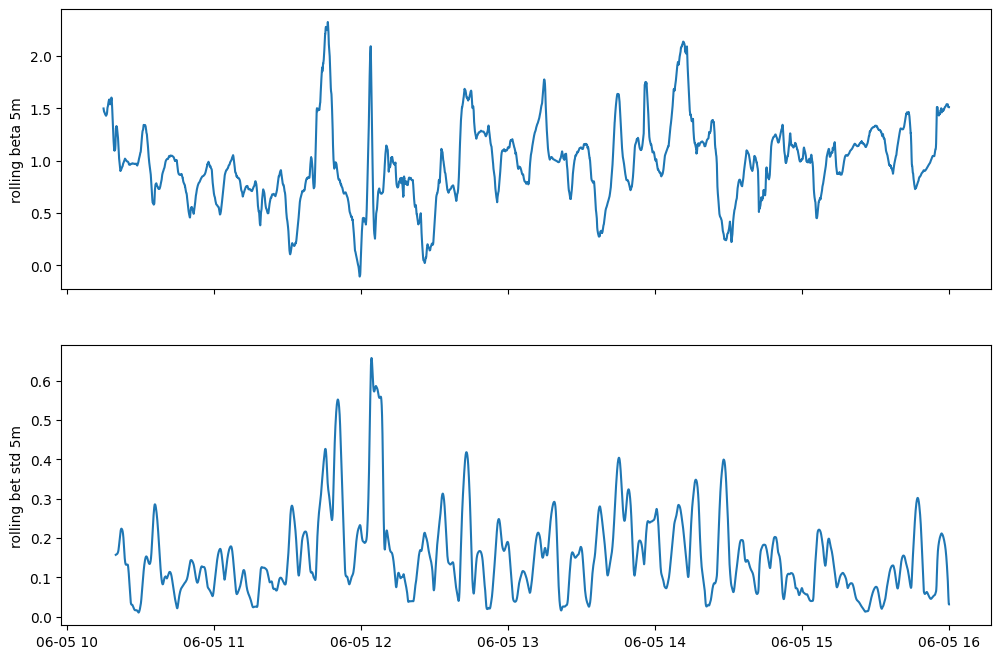

In [268]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax1.plot(df_hedge_30m['beta'])
ax2.plot(df_hedge_30m['beta_std_30m'])

ax1.set_ylabel('rolling beta 5m')
ax2.set_ylabel('rolling bet std 5m')

1) beta CV

In [269]:
# beta CV
beta_mean = df_hedge_30m['beta'].mean()
beta_std  = df_hedge_30m['beta'].std()
cv_beta = beta_std / abs(beta_mean)

cv_beta

0.3881416429012936

> beta is highly unstable -> seems to be regime driven relationship

2. beta std instability episodic test


In [248]:
q80 = df_hedge_30s['beta_std_5m'].quantile(0.8)
unstable_frac = (df_hedge_30s['beta_std_5m'] > q80).mean()
unstable_frac

0.19225940516905493

> acceptable level of beta std

3. Smoothness test (check risky jump)

In [249]:
db = df_hedge_30s['beta'].diff()
jump_rate = (db.abs() > 3 * db.std()).mean()
jump_rate

0.019914282003549937

> rare jump

4. Sanity check

In [271]:
df_hedge_30m[['beta_std_30m', 'eps']].corr()


,beta_std_30m,eps
beta_std_30m,1.000000,-0.092216
eps,-0.092216,1.000000


## Factor Neutral RV

$r_t^{GS} = \alpha_t^{GS} + \beta_{XLF,t}^{GS} r_t^{XLF} + \beta_{SPY,t}^{GS} r_t^{SPY} $

$r_t^{MS} = \alpha_t^{MS} + \beta_{XLF,t}^{MS} r_t^{XLF} + \beta_{SPY,t}^{MS} r_t^{SPY} $

$s_t = \epsilon_t^{GS} - \epsilon_t^{MS}$

In [274]:
BASE = Path("../data")

tickers = ["GS", "MS", "SPY", "XLF"]
date = '2025-06-05'

df_dict = {}
for sym in tickers:
    quotes_fp_gs = BASE / "quotes" / f"{sym}_quotes_1s_{date}.parquet"
    prices_fp_gs = BASE / "prices" / f"{sym}_1s_{date}.parquet"
    trades_fp_gs = BASE / "trades" / f"{sym}_trades_1s_{date}.parquet"

    panel = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
    df_dict[f"{sym}_mid"] = panel['q_mid']

df = pd.DataFrame(df_dict).dropna()
df

,GS_mid,MS_mid,SPY_mid,XLF_mid
ts,,,,
2025-06-05 09:30:01-04:00,599.450,128.370,597.510,50.865
2025-06-05 09:30:02-04:00,599.540,128.370,597.425,50.865
2025-06-05 09:30:03-04:00,599.430,128.370,597.455,50.855
2025-06-05 09:30:04-04:00,599.385,128.370,597.575,50.855
2025-06-05 09:30:05-04:00,599.250,128.370,597.640,50.855
...,...,...,...,...
2025-06-05 15:59:55-04:00,606.065,130.675,593.135,50.665
2025-06-05 15:59:56-04:00,606.070,130.665,593.135,50.665
2025-06-05 15:59:57-04:00,606.135,130.645,593.055,50.655


In [276]:
ret_h = 30  # 30 seconds

rGS  = np.log(df['GS_mid']).diff(ret_h)
rMS  = np.log(df['MS_mid']).diff(ret_h)
rXLF = np.log(df['XLF_mid']).diff(ret_h)
rSPY = np.log(df['SPY_mid']).diff(ret_h)

panel = pd.DataFrame({'r_GS': rGS, 'r_MS': rMS, 'r_XLF': rXLF, 'r_SPY': rSPY}).dropna()
panel

,r_GS,r_MS,r_XLF,r_SPY
ts,,,,
2025-06-05 09:30:31-04:00,-0.000993,-0.002652,-0.000197,0.000310
2025-06-05 09:30:32-04:00,-0.001594,-0.000779,-0.000197,0.000502
2025-06-05 09:30:33-04:00,-0.001494,-0.000779,0.000000,0.000485
2025-06-05 09:30:34-04:00,-0.001436,-0.000779,0.000000,0.000343
2025-06-05 09:30:35-04:00,-0.001244,-0.000779,0.000000,0.000234
...,...,...,...,...
2025-06-05 15:59:55-04:00,0.001098,0.001149,0.000790,0.000734
2025-06-05 15:59:56-04:00,0.001123,0.001110,0.000790,0.000835
2025-06-05 15:59:57-04:00,0.001321,0.000957,0.000790,0.000675


In [313]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

dict_eps = {}

for target in ["GS", "MS"]:
    y = panel[f"r_{target}"]
    X = sm.add_constant(panel[['r_XLF', 'r_SPY']])

    rols = RollingOLS(y, X, window=60)
    res = rols.fit()

    beta = res.params
    # calculate epsilon
    y_hat = (beta * X).sum(axis=1)
    eps =  y - y_hat
    dict_eps[f"eps_{target}"] = eps

df_eps = pd.DataFrame(dict_eps)
df_eps['eps_spread'] = (df_eps['eps_GS'] - df_eps['eps_MS']).dropna()


df_eps.head()
    


,eps_GS,eps_MS,eps_spread
ts,,,
2025-06-05 09:30:31-04:00,-0.000993,-0.002652,0.001659
2025-06-05 09:30:32-04:00,-0.001594,-0.000779,-0.000815
2025-06-05 09:30:33-04:00,-0.001494,-0.000779,-0.000715
2025-06-05 09:30:34-04:00,-0.001436,-0.000779,-0.000657
2025-06-05 09:30:35-04:00,-0.001244,-0.000779,-0.000465


In [314]:
df_eps.describe()

,eps_GS,eps_MS,eps_spread
count,23369.000000,23369.000000,2.336900e+04
mean,0.000001,0.000001,-5.898934e-08
std,0.000270,0.000220,2.861824e-04
min,-0.001905,-0.002652,-2.736056e-03
25%,-0.000130,-0.000112,-1.409937e-04
50%,0.000002,0.000002,5.487384e-06
75%,0.000134,0.000118,1.427213e-04
max,0.002329,0.002075,4.136684e-03


> eps stats looks stable

In [315]:
W = 30

# avoid look ahead bias by shifting 1
mu = df_eps['eps_spread'].rolling(W).mean().shift(1)
sd = df_eps['eps_spread'].rolling(W).std(ddof=1).shift(1)

df_eps['s_z'] = (df_eps['eps_spread'] - mu) / sd
df_eps.dropna(inplace=True)
df_eps

,eps_GS,eps_MS,eps_spread,s_z
ts,,,,
2025-06-05 09:31:01-04:00,0.000184,0.001873,-0.001689,-3.339575
2025-06-05 09:31:02-04:00,0.000626,0.000000,0.000626,0.673870
2025-06-05 09:31:03-04:00,0.000710,0.000000,0.000710,0.757411
2025-06-05 09:31:04-04:00,-0.000577,0.000000,-0.000577,-1.440193
2025-06-05 09:31:05-04:00,-0.000543,-0.000039,-0.000504,-1.333178
...,...,...,...,...
2025-06-05 15:59:55-04:00,0.000504,0.000638,-0.000134,-0.709231
2025-06-05 15:59:56-04:00,0.000517,0.000679,-0.000163,-0.812649
2025-06-05 15:59:57-04:00,0.000612,0.000303,0.000309,1.369393


### Factor Leakage Regression

$\Delta s_k = \lambda_{SPY}r_k^{SPY} + \lambda_{XLF} r_{k}^{XLF} + \eta_k$

In [316]:
def build_position_from_z(z: pd.Series, z_in=2.0, z_out=0.5) -> pd.Series:
    pos = pd.Series(0, index=z.index, dtype=float)
    curr = 0.0
    for t in z.index:
        if z.loc[t] > z_in:
            curr = -1.0
        elif z.loc[t] < -z_in:
            curr = +1.0
        elif abs(z.loc[t]) < z_out:
            curr = 0.0
        # else keep curr
        pos.loc[t] = curr
    return pos


def conditional_leakage_test(spread: pd.Series, r_spy: pd.Series, r_xlf: pd.Series, pos: pd.Series):
    # align
    df = pd.concat(
        {"s": spread, "spy": r_spy, "xlf": r_xlf, "pos": pos},
        axis=1
    ).dropna()

    # use delta spread (closer to "hold PnL driver")
    df["ds"] = df["s"].diff()
    df = df.dropna()

    held = df["pos"] != 0

    def run(sample_mask, name):
        X = sm.add_constant(df.loc[sample_mask, ["spy", "xlf"]])
        y = df.loc[sample_mask, "ds"]
        model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})  # HAC helps with autocorr
        out = {
            "sample": name,
            "n": int(sample_mask.sum()),
            "lambda_spy": float(model.params["spy"]),
            "lambda_xlf": float(model.params["xlf"]),
            "t_spy": float(model.tvalues["spy"]),
            "t_xlf": float(model.tvalues["xlf"]),
            "r2": float(model.rsquared),
        }
        return out

    return pd.DataFrame([
        run(held, "HELD (pos!=0)"),
        run(~held, "NOT_HELD (pos==0)"),
        run(np.ones(len(df), dtype=bool), "ALL"),
    ])

In [317]:
df_eps['pos'] = build_position_from_z(df_eps['s_z'])

conditional_leakage_test(df_eps['eps_spread'], panel['r_SPY'], panel['r_XLF'], df_eps['pos'])

,sample,n,lambda_spy,lambda_xlf,t_spy,t_xlf,r2
0,HELD (pos!=0),8306,-0.005283,0.000442,-0.397119,0.036631,0.000080
1,NOT_HELD (pos==0),15032,0.012302,-0.010250,2.327590,-1.852502,0.000327
2,ALL,23338,0.006224,-0.006563,1.120907,-1.189548,0.000068
